## Content
Data: 29 Oct 2023
number of sample: 19

- Pre 1: Load libraries
- Pre 2: Load data
  - split training set & testing set

1. Data processing
  1. Clean the comments with neutral words
  - option 1: NLTK - stop words
  - option 2: SK_Learn - ENGLISH_STOP_WORDS
  2. Stemming or lemmatization
  3. clean the text with embedding (Glove/ Fasttext)
  4. Clean text per N-gram
  5. Inspection after processing

2. Features engineering
  1. Sentiment analysis on top n-grams
      - option 1 - NLTK
      - option 2 - Textblob
      - option 3 - specific for financial terms
  2. Time-series

    
3. Prepare the Training dataset
  1. check for Duplicated labeled records
  2. normalise

## Pre 1: Load libraries

In [1]:
# import library

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re
import string

import gc
import operator

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:
# popular Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

!pip install bert-tensorflow
from bert import tokenization

from collections import defaultdict

import seaborn as sns

from wordcloud import STOPWORDS

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.0 MB/s eta 0:00:00


In [3]:
#Load the 2 popular embedding 
#glove
#fasttext

glove_embeddings = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)
fasttext_embeddings = np.load('../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl', allow_pickle=True)

In [4]:
# Embeddings Coverage

# break the comments into words
# vocab is the unique words in the text data
def build_vocab(X):

    comments = X.apply(lambda s: s.split()).values
    vocab = {}

    for comment in comments:
        for word in comment:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


def check_embeddings_coverage(X, embeddings):

    vocab = build_vocab(X)

    covered = {}
    oov = {}
    n_covered = 0
    n_oov = 0

    for word in vocab:
        try:
            covered[word] = embeddings[word] #函式嘗試將當前單詞加入到covered中，如果該單詞可以在embeddings中找到對應的向量
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word] # 否則，函式將當前單詞加入到oov中，表示該單詞未被涵蓋
            n_oov += vocab[word]

    #calculate the coverage
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))

    # 函式將oov字典按照值（即未涵蓋的單詞數量）進行排序，並以元祖列表的形式返回
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

In [5]:
def generate_ngrams(text, n_gram=1):
    # tokenisation
    # convert to lower case
    # split words based on spaces.
    # filter out empty tokens and stopwords
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]

    # grouping tokens to form n-grams
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    # joins the tokens within each ngram using the ' ' separator and as 1 string
    return [' '.join(ngram) for ngram in ngrams]

# visualisation how long of N-grams
N = 100

## Pre 2: Load data

In [6]:
#load excel
consol_df = pd.read_csv("../input/concat-reddit-df-oct22-jun23/concat_Reddit_df_Oct22-Jun23.csv", index_col=0)

consol_df.set_index('date', inplace=True)

consol_df

,comments,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_SP500,percent_chnage_x,Jump_SP500,Big_Jump_SP500,...,High_y,Low_y,Close_y,Adj Close_y,Volume_NQ,percent_chnage_y,Jump_NQ,Big_Jump_NQ,Drop_NQ,Big_Drop_NQ
date,,,,,,,,,,,,,,,,,,,,,
2022-07-13,This week's [Earnings Thread](https://www.redd...,11056.54980,11325.66992,11031.26953,11247.58008,11247.58008,4433060000,1.727757,0,1,...,3829.439941,3759.070068,3801.780029,3801.780029,4109390000,0.584975,1,0,0,0
2022-07-14,This week's [Earnings Thread](https://www.redd...,11151.20996,11279.96973,11005.92969,11251.19043,11251.19043,4481070000,0.896589,1,0,...,3796.409912,3721.560059,3790.379883,3790.379883,4199690000,0.701115,1,0,0,0
2022-07-15,Cashed out up 56k today. Now cuddled up watchi...,11379.36035,11454.69043,11295.33008,11452.41992,11452.41992,4369060000,0.642036,1,0,...,3863.620117,3817.179932,3863.159912,3863.159912,4143800000,1.182816,0,1,0,0
2022-07-19,This week's [Earnings Thread](https://www.redd...,11515.00000,11721.21973,11448.96973,11713.15039,11713.15039,5302740000,1.720802,0,1,...,3939.810059,3860.729980,3936.689941,3936.689941,4041070000,1.967503,0,1,0,0
2022-07-20,If 2008 was the Great Recession\n\nThen 2022 i...,11726.08984,11939.95996,11703.36035,11897.65039,11897.65039,5467080000,1.463067,0,1,...,3974.129883,3922.030029,3959.899902,3959.899902,4185300000,0.624596,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,I was holding puts over the weekend. Thought f...,13468.74023,13573.57031,13334.41992,13335.78027,13335.78027,4430600000,-0.987174,0,0,...,4362.060059,4328.080078,4328.819824,4328.819824,3415030000,-0.368714,0,0,1,0
2023-06-27,I watched TSLA rise for 3 months. 3 months. 3 ...,13389.25000,13578.79980,13366.96973,13555.66992,13555.66992,5053660000,1.242937,0,1,...,4384.419922,4335.000000,4378.410156,4378.410156,3573500000,0.946435,1,0,0,0
2023-06-28,Trades when I 15x: $300 invested\n\nTrades whe...,13506.01953,13654.13965,13495.73047,13591.75000,13591.75000,4533270000,0.634757,1,0,...,4390.350098,4360.220215,4376.859863,4376.859863,3739330000,0.214766,1,0,0,0


In [7]:
# combine df
'''
consol_df = pd.concat([part1_df, part2_df], ignore_index=True)
consol_df
'''

'\nconsol_df = pd.concat([part1_df, part2_df], ignore_index=True)\nconsol_df\n'

In [8]:
# split training set & testing set

train_df = consol_df[:150].reset_index()

test_df = consol_df[150:191].reset_index()

# test_df = pd.concat([consol_df.iloc[:40], consol_df.iloc[111:]]).reset_index()

test_df

,date,comments,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_SP500,percent_chnage_x,Jump_SP500,...,High_y,Low_y,Close_y,Adj Close_y,Volume_NQ,percent_chnage_y,Jump_NQ,Big_Jump_NQ,Drop_NQ,Big_Drop_NQ
0,2023-05-02,"I will be suing the market for $295,000 if it ...",12198.01953,12206.58008,12015.23047,12080.50977,12080.50977,5501410000,-0.963351,0,...,4164.100098,4089.719971,4119.580078,4119.580078,4486130000,-1.069139,0,0,0,1
1,2023-05-03,AMD's only hope is that Su Bae spreads open he...,12097.04004,12212.54980,12022.45996,12025.33008,12025.33008,5782160000,-0.592789,0,...,4148.299805,4088.860107,4090.750000,4090.750000,4246510000,-0.764146,0,0,1,0
2,2023-05-04,I fucking hate the stock market!!!! Been a bea...,11997.33984,12033.15039,11925.37012,11966.40039,11966.40039,4745780000,-0.257886,0,...,4082.610107,4048.280029,4061.219971,4061.219971,4920090000,-0.522469,0,0,1,0
3,2023-05-05,"🍏✋😮‍💨✋🍎\n\n""Take the green aapl, and wake up t...",12073.03027,12264.83008,12065.71973,12235.41016,12235.41016,4574790000,1.344980,0,...,4147.020020,4084.729980,4136.250000,4136.250000,4186270000,1.261283,0,1,0,0
4,2023-05-08,Hardest part of Forex trading is telling your ...,12231.67969,12264.99023,12178.25977,12256.91992,12256.91992,4216360000,0.206351,1,...,4142.299805,4123.810059,4138.120117,4138.120117,3641640000,0.027560,1,0,0,0
5,2023-05-09,PLTR is up 16% and I’m still down 50% on my po...,12195.78027,12216.12988,12174.05957,12179.54980,12179.54980,4126780000,-0.133083,0,...,4130.350098,4116.649902,4119.169922,4119.169922,3810140000,-0.123176,0,0,1,0
6,2023-05-10,I did the math. I lost 15 years worth of savin...,12286.66016,12337.69043,12180.86035,12306.44043,12306.44043,4948260000,0.160990,1,...,4154.279785,4098.919922,4137.640137,4137.640137,4057160000,-0.147212,0,0,1,0
7,2023-05-11,>$BYND UP FOLLOWING EARNINGS AFTER ANNOUNCING ...,12321.25977,12347.37988,12255.44043,12328.50977,12328.50977,4489490000,0.058841,1,...,4132.799805,4109.290039,4130.620117,4130.620117,3752900000,-0.039207,0,0,1,0
8,2023-05-12,"Warren Buffett *""If you don't find a way to ma...",12350.51953,12364.65039,12209.58008,12284.74023,12284.74023,4170000000,-0.532603,0,...,4143.740234,4099.120117,4124.080078,4124.080078,3533740000,-0.349398,0,0,1,0
9,2023-05-15,Someone in here is going to post a 20 bagger p...,12301.16992,12376.40039,12263.34961,12365.20996,12365.20996,3979290000,0.520601,1,...,4141.250000,4110.270020,4136.279785,4136.279785,3562170000,0.233358,1,0,0,0


## 1. Data processing
  1. Clean the comments with neutral words
  - option 1: NLTK - stop words
  - option 2: SK_Learn - ENGLISH_STOP_WORDS
  2. Stemming or lemmatization
  3. clean the text with embedding (Glove/ Fasttext)
  4. Clean text per N-gram
  5. Inspection after processing

## 1.1 Clean the comments with neutral words

In [9]:
# option 1: NLTK - stop words

import nltk
from nltk.corpus import stopwords

In [10]:
# option 1: NLTK - stop words
# to clean the data set

# Get the stopwords
stopwords = stopwords.words('english')

# Apply preprocessing to each comment

#decode it with utf-8

train_df['new_text'] = train_df['comments'].apply(lambda text: text.encode('latin-1', errors='ignore').decode('utf-8', errors='ignore'))

'''
# Tokenization
# Split the raw text into individual tokens
consol_df['new_text'] = consol_df['new_text'].apply(word_tokenize)
'''

#convert to all small case

train_df['new_text'] = train_df['new_text'].apply(lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stopwords]))

# Print the updated DataFrame
print(train_df)

# do same to text_df
test_df['new_text'] = test_df['comments'].apply(lambda text: text.encode('latin-1', errors='ignore').decode('utf-8', errors='ignore'))
test_df['new_text'] = test_df['new_text'].apply(lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stopwords]))



           date                                           comments  \
0    2022-07-13  This week's [Earnings Thread](https://www.redd...   
1    2022-07-14  This week's [Earnings Thread](https://www.redd...   
2    2022-07-15  Cashed out up 56k today. Now cuddled up watchi...   
3    2022-07-19  This week's [Earnings Thread](https://www.redd...   
4    2022-07-20  If 2008 was the Great Recession\n\nThen 2022 i...   
..          ...                                                ...   
145  2023-04-25  Phone is glitched, FRC not showing $110 If I d...   
146  2023-04-26  6 months ago, I couldn’t even afford to get gu...   
147  2023-04-27  META up 135% since Cramer cried on live TV and...   
148  2023-04-28  A trillion dollar company up 10% in after hour...   
149  2023-05-01  1989 : The Little Mermaid\n\n2023 : The Lil Me...   

          Open_x       High_x        Low_x      Close_x  Adj Close_x  \
0    11056.54980  11325.66992  11031.26953  11247.58008  11247.58008   
1    11151.2099

In [11]:
# option 2: SK learn - ENGLISH_STOP_WORDS

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(ENGLISH_STOP_WORDS)

frozenset({'several', 'thereafter', 'more', 'together', 'ours', 'himself', 'sometimes', 'at', 'enough', 'see', 'an', 'indeed', 'nor', 'will', 'show', 'twelve', 'but', 'anyway', 'our', 'amount', 'hasnt', 'wherever', 'only', 'can', 'whose', 'been', 'keep', 'interest', 'per', 'fifteen', 'five', 'without', 'me', 'than', 'system', 'any', 'although', 'towards', 'seemed', 'latter', 'had', 'into', 'these', 'beforehand', 'whereafter', 'my', 'hereafter', 'whether', 'themselves', 'might', 'would', 'was', 'eleven', 'same', 'in', 'eg', 'fifty', 'therefore', 'well', 'a', 'of', 'often', 'sometime', 'whence', 'namely', 'anywhere', 'become', 'by', 'three', 'six', 'which', 'another', 'each', 'once', 'yourself', 'thereupon', 'do', 'other', 'after', 'find', 'back', 'front', 'least', 'serious', 'among', 'elsewhere', 'out', 'onto', 'side', 'to', 'whom', 'ever', 'own', 'go', 'else', 'besides', 'via', 'thereby', 'further', 'none', 'all', 'becoming', 'now', 'never', 'please', 'through', 'down', 'call', 'meanwh

In [12]:
# option 2: SK learn - ENGLISH_STOP_WORDS
# to clean the date set

# Get the stopwords
stopwords_sk = ENGLISH_STOP_WORDS

#convert to lower cases
# Apply preprocessing to each comment
train_df['new_text'] = train_df['new_text'].apply(lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stopwords_sk]))

# Print the updated DataFrame
print(train_df)

#do same to test set
test_df['new_text'] = test_df['new_text'].apply(lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stopwords_sk]))


           date                                           comments  \
0    2022-07-13  This week's [Earnings Thread](https://www.redd...   
1    2022-07-14  This week's [Earnings Thread](https://www.redd...   
2    2022-07-15  Cashed out up 56k today. Now cuddled up watchi...   
3    2022-07-19  This week's [Earnings Thread](https://www.redd...   
4    2022-07-20  If 2008 was the Great Recession\n\nThen 2022 i...   
..          ...                                                ...   
145  2023-04-25  Phone is glitched, FRC not showing $110 If I d...   
146  2023-04-26  6 months ago, I couldn’t even afford to get gu...   
147  2023-04-27  META up 135% since Cramer cried on live TV and...   
148  2023-04-28  A trillion dollar company up 10% in after hour...   
149  2023-05-01  1989 : The Little Mermaid\n\n2023 : The Lil Me...   

          Open_x       High_x        Low_x      Close_x  Adj Close_x  \
0    11056.54980  11325.66992  11031.26953  11247.58008  11247.58008   
1    11151.2099

## 1.2. clean the text with embedding (Glove/ Fasttext) - for sentiment analysis

In [13]:
# 1. clean the text with embedding
# clean the text
# then check coverage on the cleaned text again


# Convert 'consol_df['tokens']' column to string
train_df['new_text'] = train_df['new_text'].astype(str)
test_df['new_text'] = test_df['new_text'].astype(str)


def clean(comment):


    # #1 - eomte

    emote_pattern = r"!\[img]\(emote\|[^)]*\)"  # Regex pattern to match the desired pattern
    comment = re.sub(emote_pattern,"", comment)


    # Urls
    comment = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", comment)

    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^,' + "'`’"
    for p in punctuations:
        comment = comment.replace(p, ' ')

    return comment

train_df['embeddings_tokens'] = train_df['new_text'].apply(lambda s : clean(s))
test_df['embeddings_tokens'] = test_df['new_text'].apply(lambda s : clean(s))

glove_oov, glove_vocab_coverage, glove_text_coverage = check_embeddings_coverage(train_df['embeddings_tokens'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(glove_vocab_coverage, glove_text_coverage))

fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = check_embeddings_coverage(train_df['embeddings_tokens'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(fasttext_vocab_coverage, fasttext_text_coverage))


GloVe Embeddings cover 52.91% of vocabulary and 96.33% of text in Training Set
FastText Embeddings cover 51.72% of vocabulary and 96.49% of text in Training Set


In [14]:
# count the removed pattern
'''
def df_pattern(comment, df):

    emote_pattern = r"!\[img]\(emote\|[^)]*\)"  # Regex pattern to match the desired pattern
    matches = re.findall(emote_pattern, comment)
    pattern_counts = {}

      # Count the patterns
    for match in matches:
        if match in pattern_counts:
            pattern_counts[match] += 1
        else:
            pattern_counts[match] = 1

    df_input = pd.DataFrame({'Count': list(pattern_counts.values())}, index=list(pattern_counts.keys()))
    df_transposed = df.T
    df = df.append(df_transposed, ignore_index=False)

    return df

#initialise
df_pattern = pd.DataFrame()

# Create a dataframe from the pattern counts
df_pattern = (consol_df['new_text'],df_pattern).apply(lambda s : df_pattern(s))
df_pattern['date'] = consol_df['date']

'''

'\ndef df_pattern(comment, df):\n\n    emote_pattern = r"!\\[img]\\(emote\\|[^)]*\\)"  # Regex pattern to match the desired pattern\n    matches = re.findall(emote_pattern, comment)\n    pattern_counts = {}\n\n      # Count the patterns\n    for match in matches:\n        if match in pattern_counts:\n            pattern_counts[match] += 1\n        else:\n            pattern_counts[match] = 1\n\n    df_input = pd.DataFrame({\'Count\': list(pattern_counts.values())}, index=list(pattern_counts.keys()))\n    df_transposed = df.T\n    df = df.append(df_transposed, ignore_index=False)\n\n    return df\n\n#initialise\ndf_pattern = pd.DataFrame()\n\n# Create a dataframe from the pattern counts\ndf_pattern = (consol_df[\'new_text\'],df_pattern).apply(lambda s : df_pattern(s))\ndf_pattern[\'date\'] = consol_df[\'date\']\n\n'

In [15]:
# 1. clean the text with embedding
# save a copy of clean text
'''
consol_df.to_csv('consol_df.csv')
'''

"\nconsol_df.to_csv('consol_df.csv')\n"

In [16]:
# consol_df = pd.read_csv('consol_df.csv')

In [17]:
# 1. clean the text with embedding
# After cleaning, glove_embeddings and fasttext_embeddings are deleted and garbage collected because they consume too much memory (10+ gigabytes).
'''
del glove_embeddings, fasttext_embeddings, glove_oov, fasttext_oov,
gc.collect()
'''

'\ndel glove_embeddings, fasttext_embeddings, glove_oov, fasttext_oov,\ngc.collect()\n'

In [18]:
# 2nd round cleaned
# generate ngrams in the cleaned text
# Unigrams
consol_unigrams_cleaned_second = defaultdict(int)

for cmt in train_df['embeddings_tokens']:
    for word in generate_ngrams(cmt):
        consol_unigrams_cleaned_second[word] += 1

df_unigrams_cleaned_second = pd.DataFrame(sorted(consol_unigrams_cleaned_second.items(), key=lambda x: x[1])[::-1],columns=['grams', 'count'])

# Bigrams
consol_bigrams_cleaned_second = defaultdict(int)

for cmt in train_df['embeddings_tokens']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams_cleaned_second[word] += 1

df_bigrams_cleaned_second = pd.DataFrame(sorted(consol_bigrams_cleaned_second.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

# Trigrams
consol_trigrams_cleaned_second = defaultdict(int)

for cmt in train_df['embeddings_tokens']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams_cleaned_second[word] += 1

df_trigrams_cleaned_second = pd.DataFrame(sorted(consol_trigrams_cleaned_second.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

df_bigrams_cleaned_second

,grams,count
0,https reddit,13308
1,reddit wallstreetbets,11955
2,wallstreetbets wiki,10365
3,message compose,8657
4,compose wallstreetbets,8033
...,...,...
3807066,dataa know,1
3807067,old dataa,1
3807068,the_wsb_trash_bin_discussion_thread_for_the_we...,1
3807069,v96vnt the_wsb_trash_bin_discussion_thread_for...,1


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

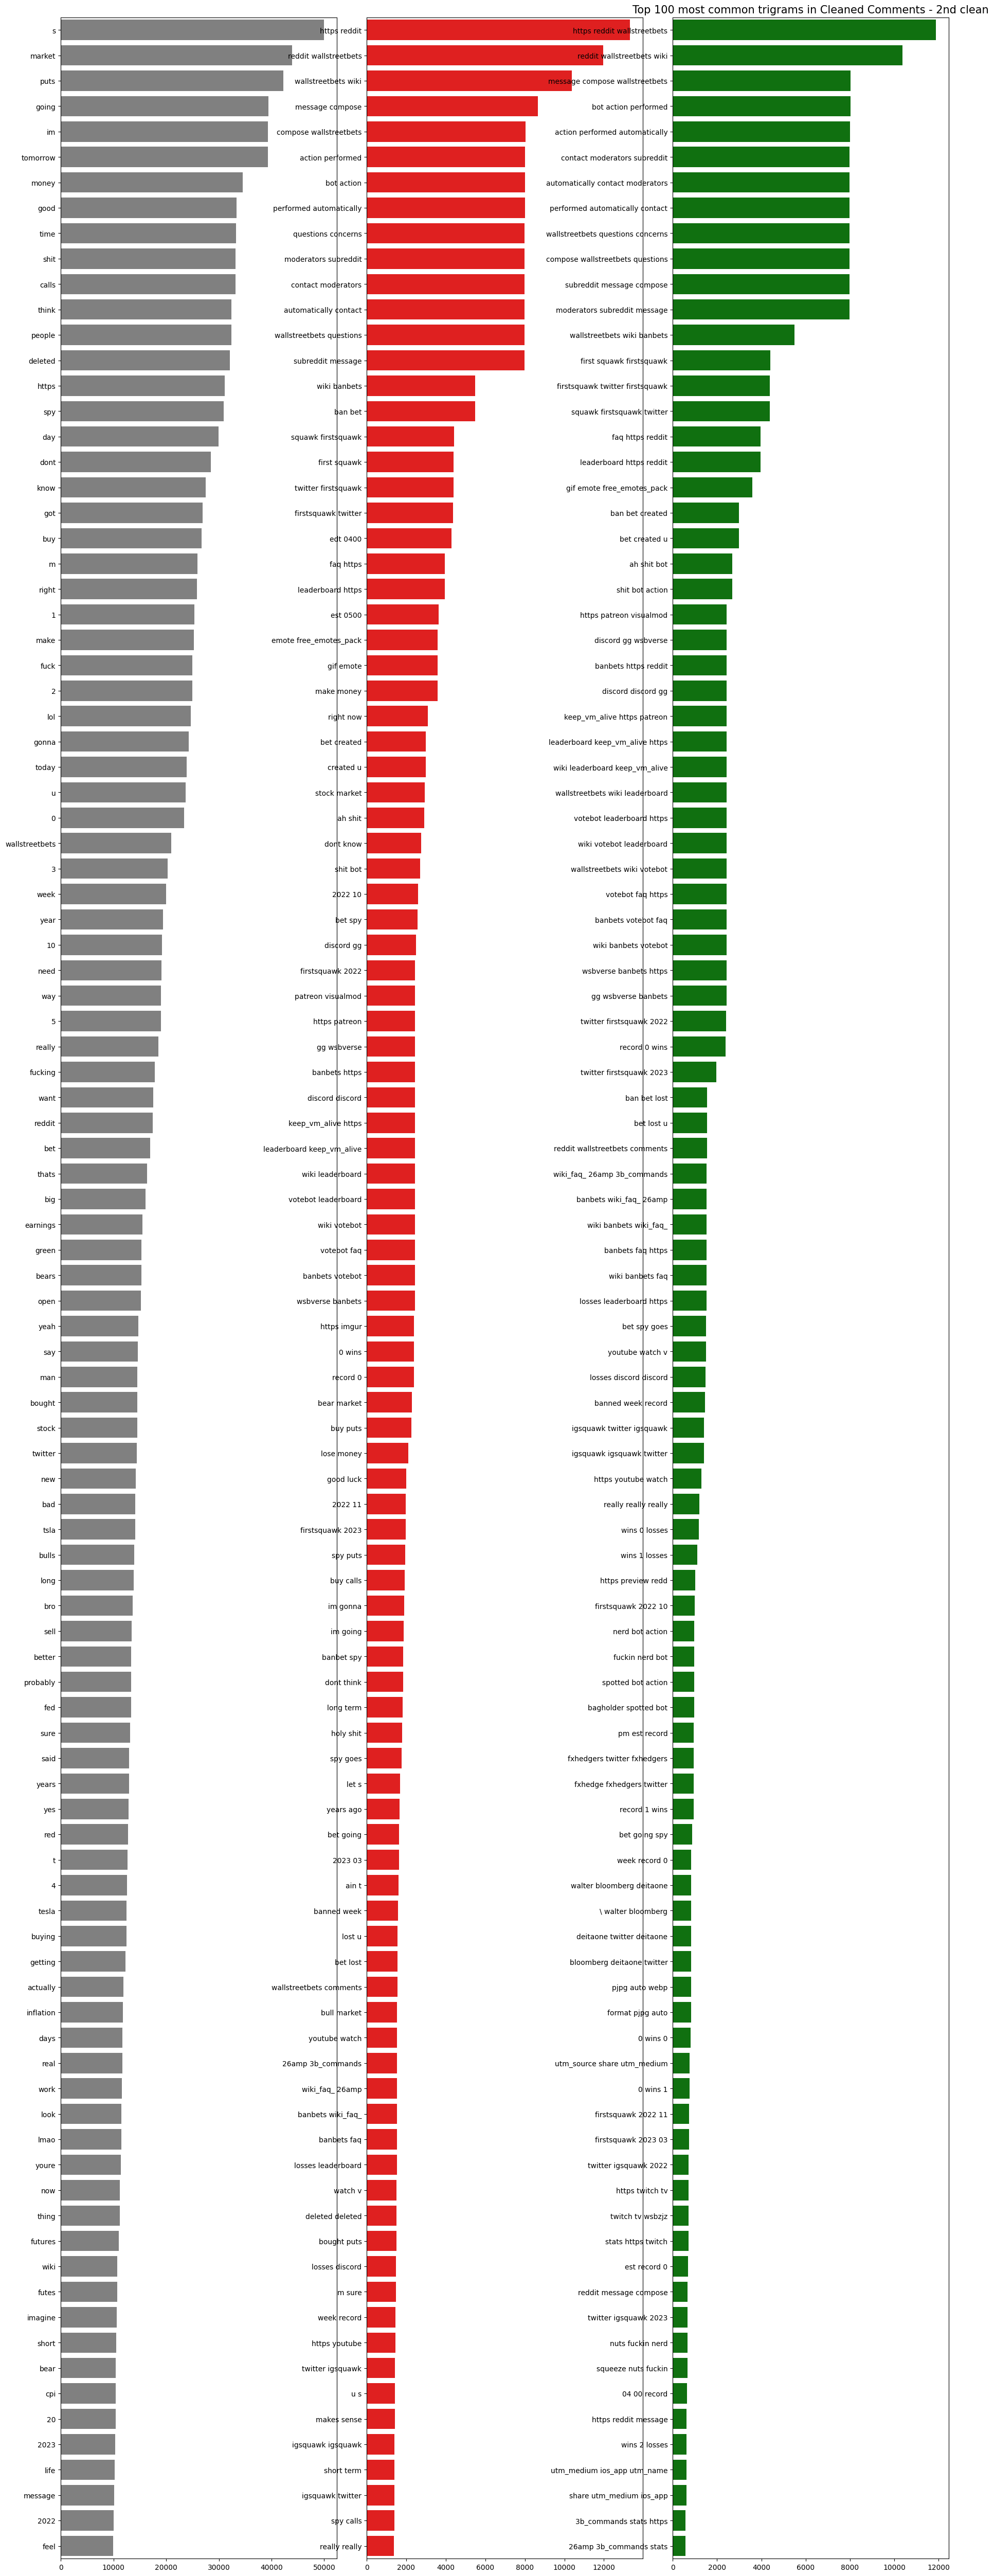

In [19]:
# 2nd round cleaned
# visualisation for N-grams cleaned

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams_cleaned_second['grams'].values[:N], x=df_unigrams_cleaned_second['count'].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Cleaned Comments - 2nd clean', fontsize=15)

sns.barplot(y=df_bigrams_cleaned_second['grams'].values[:N], x=df_bigrams_cleaned_second['count'].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Cleaned Comments - 2nd clean', fontsize=15)

sns.barplot(y=df_trigrams_cleaned_second['grams'].values[:N], x=df_trigrams_cleaned_second['count'].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Cleaned Comments - 2nd clean', fontsize=15)

plt.show()

## 1.3. Clean per N-gram

In [20]:
# 3rd round cleaned
# criteria: by reading the N-gram ranking


def clean_second(comment):

    comment = re.sub(r"\bai ai ai\b", "ai", comment)
    comment = re.sub(r"\bai ai\b", "ai", comment)
    comment = re.sub(r'compose', '', comment)
    comment = re.sub(r'moderators', '', comment)
    comment = re.sub(r'\bm\b', '', comment)
    comment = re.sub(r'\bs\b', '', comment)
    comment = re.sub(r'\bu\b', '', comment)
    comment = re.sub(r'\b1\b', '', comment)
    comment = re.sub(r'\b2\b', '', comment)
    comment = re.sub(r'\bim\b', '', comment)
    comment = re.sub(r"   ", " ", comment)
    comment = re.sub(r"  ", " ", comment)


    return comment

train_df['ngrams_embeddings_tokens'] = train_df['embeddings_tokens'].apply(lambda s : clean_second(s))
test_df['ngrams_embeddings_tokens'] = test_df['embeddings_tokens'].apply(lambda s : clean_second(s))

glove_oov, glove_vocab_coverage, glove_text_coverage = check_embeddings_coverage(train_df['ngrams_embeddings_tokens'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set - 3rd clean'.format(glove_vocab_coverage, glove_text_coverage))

fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = check_embeddings_coverage(train_df['ngrams_embeddings_tokens'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set - 3rd clean'.format(fasttext_vocab_coverage, fasttext_text_coverage))

GloVe Embeddings cover 52.92% of vocabulary and 96.25% of text in Training Set - 3rd clean
FastText Embeddings cover 51.73% of vocabulary and 96.40% of text in Training Set - 3rd clean


In [21]:
# 3rd round cleaned
# generate ngrams in the cleaned text
# Unigrams
consol_unigrams_cleaned_third = defaultdict(int)

for cmt in train_df['ngrams_embeddings_tokens']:
    for word in generate_ngrams(cmt):
        consol_unigrams_cleaned_third[word] += 1

df_unigrams_cleaned_third = pd.DataFrame(sorted(consol_unigrams_cleaned_third.items(), key=lambda x: x[1])[::-1],columns=['grams', 'count'])

# Bigrams
consol_bigrams_cleaned_third = defaultdict(int)

for cmt in train_df['ngrams_embeddings_tokens']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams_cleaned_third[word] += 1

df_bigrams_cleaned_third = pd.DataFrame(sorted(consol_bigrams_cleaned_third.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

# Trigrams
consol_trigrams_cleaned_third = defaultdict(int)

for cmt in train_df['ngrams_embeddings_tokens']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams_cleaned_third[word] += 1

df_trigrams_cleaned_third = pd.DataFrame(sorted(consol_trigrams_cleaned_third.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

df_bigrams_cleaned_third

,grams,count
0,https reddit,13308
1,reddit wallstreetbets,11957
2,wallstreetbets wiki,10365
3,message wallstreetbets,8033
4,action performed,8019
...,...,...
3819457,dataa know,1
3819458,old dataa,1
3819459,the_wsb_trash_bin_discussion_thread_for_the_we...,1
3819460,v96vnt the_wsb_trash_bin_discussion_thread_for...,1


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

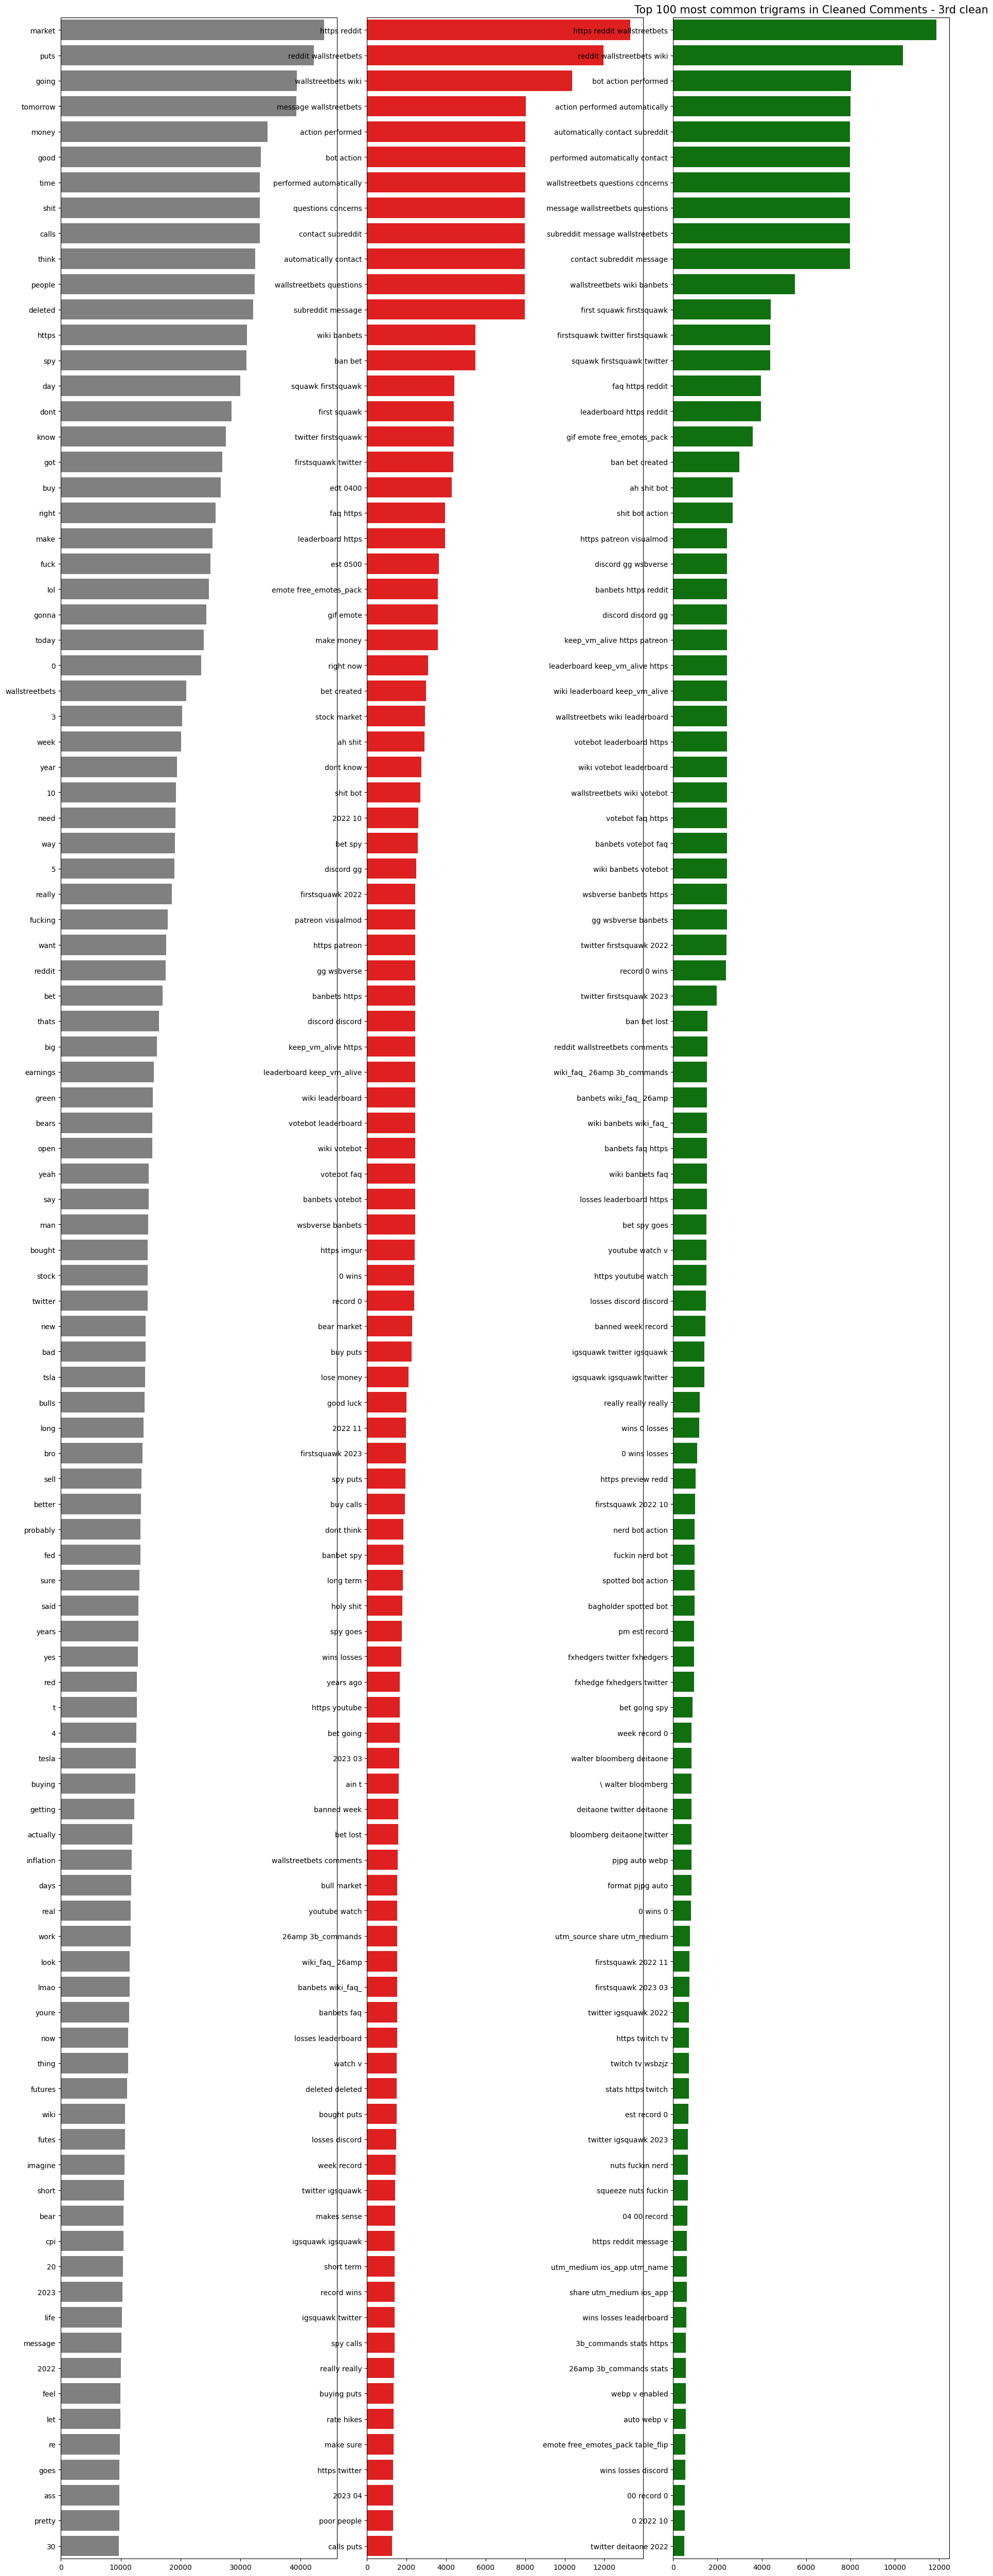

In [22]:
# 3rd round cleaned
# visualisation for N-grams cleaned

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams_cleaned_third['grams'].values[:N], x=df_unigrams_cleaned_third['count'].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Cleaned Comments - 3rd clean', fontsize=15)

sns.barplot(y=df_bigrams_cleaned_third['grams'].values[:N], x=df_bigrams_cleaned_third['count'].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Cleaned Comments - 3rd clean', fontsize=15)

sns.barplot(y=df_trigrams_cleaned_third['grams'].values[:N], x=df_trigrams_cleaned_third['count'].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Cleaned Comments - 3rd clean', fontsize=15)

plt.show()

## 1.4. Stemming or lemmatization

In [23]:
# Stemming
train_df['tokens'] = train_df['ngrams_embeddings_tokens'].apply(word_tokenize)

# Step 2: Choose a Stemming or Lemmatization Algorithm
# Select a stemming or lemmatization algorithm
stemmer = PorterStemmer()

# Step 3: Apply Stemming or Lemmatization
# Apply the chosen algorithm to each token
train_df['stemmed_tokens'] = train_df['tokens'].apply(lambda x: [stemmer.stem(token) for token in x])
# Step 4: Reconstruct the Text
# Reconstruct the text by joining the stemmed or lemmatized tokens
train_df['stemmed_text'] = train_df['stemmed_tokens'].apply(lambda x: ' '.join(x))

# do the same to test set
test_df['tokens'] = test_df['ngrams_embeddings_tokens'].apply(word_tokenize)
test_df['stemmed_tokens'] = test_df['tokens'].apply(lambda x: [stemmer.stem(token) for token in x])
test_df['stemmed_text'] = test_df['stemmed_tokens'].apply(lambda x: ' '.join(x))

In [24]:
# Lemmatization

# Select a stemming or lemmatization algorithm
lemmatizer = WordNetLemmatizer()
# Apply the chosen algorithm to each token
train_df['lemmatized_tokens'] = train_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])
# Reconstruct the text by joining the stemmed or lemmatized tokens
train_df['lemmatized_text'] = train_df['lemmatized_tokens'].apply(lambda x: ' '.join(x))

# do the same to test set
test_df['lemmatized_tokens'] = test_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])
test_df['lemmatized_text'] = test_df['lemmatized_tokens'].apply(lambda x: ' '.join(x))

LookupError: 
**********************************************************************
  Resource 'corpora/wordnet' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/root/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

##1.5. Inspection after processing

In [25]:
#  Inspection after processing
# generate ngrams in the cleaned text
# Unigrams
# adopt Stemmed text
consol_unigrams_cleaned_final = defaultdict(int)

for cmt in train_df['stemmed_text']:
    for word in generate_ngrams(cmt):
        consol_unigrams_cleaned_final[word] += 1

df_unigrams_cleaned_final = pd.DataFrame(sorted(consol_unigrams_cleaned_final.items(), key=lambda x: x[1])[::-1],columns=['grams', 'count'])

# Bigrams
consol_bigrams_cleaned_final = defaultdict(int)

for cmt in train_df['stemmed_text']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams_cleaned_final[word] += 1

df_bigrams_cleaned_final = pd.DataFrame(sorted(consol_bigrams_cleaned_final.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

# Trigrams
consol_trigrams_cleaned_final = defaultdict(int)

for cmt in train_df['stemmed_text']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams_cleaned_final[word] += 1

df_trigrams_cleaned_final = pd.DataFrame(sorted(consol_trigrams_cleaned_final.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

df_bigrams_cleaned_final

,grams,count
0,gon na,24321
1,reddit wallstreetbet,11957
2,wallstreetbet wiki,10365
3,messag wallstreetbet,8033
4,action perform,8019
...,...,...
3156376,dataa know,1
3156377,old dataa,1
3156378,the_wsb_trash_bin_discussion_thread_for_the_we...,1
3156379,v96vnt the_wsb_trash_bin_discussion_thread_for...,1


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

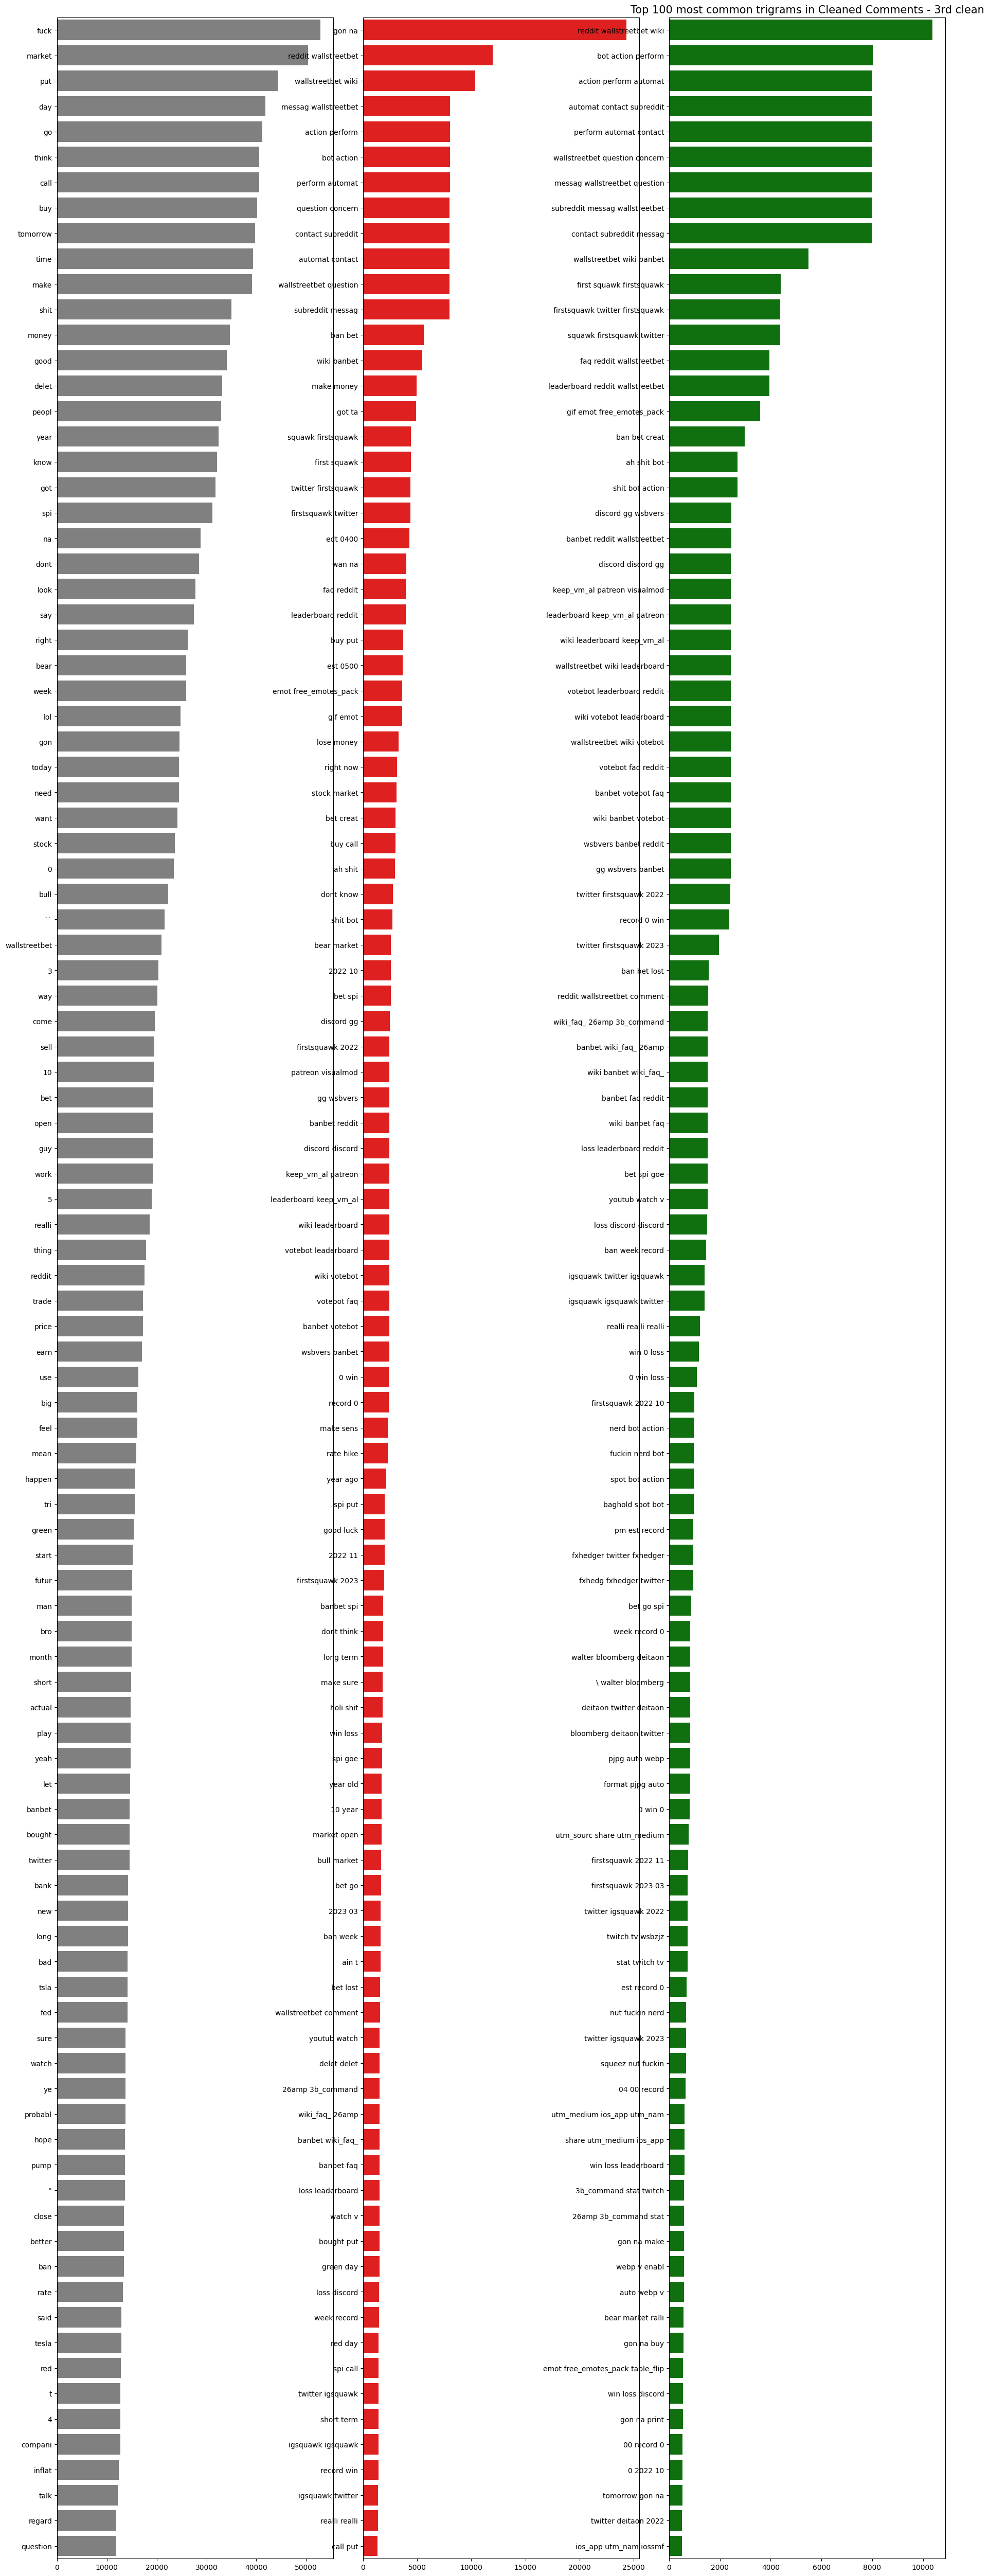

In [26]:
# Inspection after processing
# visualisation for N-grams cleaned
# adopt Stemmed text

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams_cleaned_final['grams'].values[:N], x=df_unigrams_cleaned_final['count'].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Cleaned Comments - 3rd clean', fontsize=15)

sns.barplot(y=df_bigrams_cleaned_final['grams'].values[:N], x=df_bigrams_cleaned_final['count'].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Cleaned Comments - 3rd clean', fontsize=15)

sns.barplot(y=df_trigrams_cleaned_final['grams'].values[:N], x=df_trigrams_cleaned_final['count'].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Cleaned Comments - 3rd clean', fontsize=15)

plt.show()

# 2. Features engineering

  1. Sentiment analysis on top n-grams
      - option 1 - NLTK
      - option 2 - Textblob
      - option 3 - specific for financial terms
  2. Time-series



In [27]:
# Generate the list of N-grams
# adopt Stemmed text

df_unigrams_cleaned_final_tomerge = df_unigrams_cleaned_final[:20]

'''
df_bigrams_cleaned_third_tomerge = df_bigrams_cleaned_third[:20]

df_trigrams_cleaned_third_tomerge = df_trigrams_cleaned_third[:20]
'''

df_unigrams_cleaned_final_tomerge


,grams,count
0,fuck,52825
1,market,50345
2,put,44297
3,day,41771
4,go,41239
5,think,40615
6,call,40575
7,buy,40117
8,tomorrow,39775
9,time,39357


In [28]:
# Generate the list of N-grams
# create a series contiaing first 100 unigram, bigram , trigram

list_topgram = df_unigrams_cleaned_final_tomerge['grams']
          # pd.concat([df_unigrams_cleaned_third_tomerge['grams'] , df_bigrams_cleaned_third_tomerge['grams'] , df_trigrams_cleaned_third_tomerge['grams']], axis=0)
list_topgram

0         fuck
1       market
2          put
3          day
4           go
5        think
6         call
7          buy
8     tomorrow
9         time
10        make
11        shit
12       money
13        good
14       delet
15       peopl
16        year
17        know
18         got
19         spi
Name: grams, dtype: object

In [29]:
# Generate the list of N-grams
# create a df containings n columns each with 1 key word, each row of record shows the count of frequency of each keyword in the raw text

df_topgram = pd.DataFrame(columns=list_topgram, index=train_df.index)
for i, row in train_df.iterrows():
    for gram in list_topgram:
        count = row['ngrams_embeddings_tokens'].count(gram)
        df_topgram.at[i, gram] = count

df_topgram['date'] = train_df['date']

# do the same to test set

df_topgram_test = pd.DataFrame(columns=list_topgram, index=test_df.index)
for i, row in train_df.iterrows():
    for gram in list_topgram:
        count = row['ngrams_embeddings_tokens'].count(gram)
        df_topgram_test.at[i, gram] = count

df_topgram_test['date'] = test_df['date']
df_topgram_test

grams,fuck,market,put,day,go,think,call,buy,tomorrow,time,...,shit,money,good,delet,peopl,year,know,got,spi,date
0,569,414,507,701,1582,400,532,416,527,349,...,369,290,283,250,238,266,339,294,53,2023-05-02
1,566,455,409,1005,1562,351,414,411,364,346,...,336,318,302,330,254,263,285,317,34,2023-05-03
2,486,573,523,971,1700,330,458,424,569,381,...,351,294,306,234,259,263,291,331,64,2023-05-04
3,473,360,412,746,1480,306,368,302,226,358,...,355,223,279,265,259,279,240,328,47,2023-05-05
4,585,600,663,989,1718,388,565,446,470,394,...,364,333,311,271,268,251,304,304,65,2023-05-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,338,201,140,396,1049,201,308,233,155,243,...,198,200,196,113,181,139,179,186,34,NaN
146,434,287,308,573,1620,278,355,376,299,267,...,267,202,266,178,211,169,178,236,40,NaN
147,324,303,188,437,1074,256,324,233,198,273,...,225,188,235,136,166,219,221,196,30,NaN
148,508,393,282,583,1312,254,511,300,308,238,...,270,255,249,131,163,195,223,255,46,NaN


In [30]:
# Generate the list of N-grams
#back up the training data set

df_topgram.to_csv('df_top20gram_Jun_testing.csv')

### 2.1. Sentiment analysis

In [31]:
# adoption of sentiment analysis models
# option 1 - NLTK

sia = SentimentIntensityAnalyzer()

#apply sentiment analysis
df_topgram_nltk = pd.DataFrame()
df_topgram_nltk['grams'] = list_topgram
df_topgram_nltk['sentiment_score'] = list_topgram.apply(lambda x: sia.polarity_scores(x))

df_topgram_nltk

,grams,sentiment_score
0,fuck,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound..."
1,market,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,put,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,day,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,go,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
5,think,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
6,call,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
7,buy,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
8,tomorrow,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
9,time,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


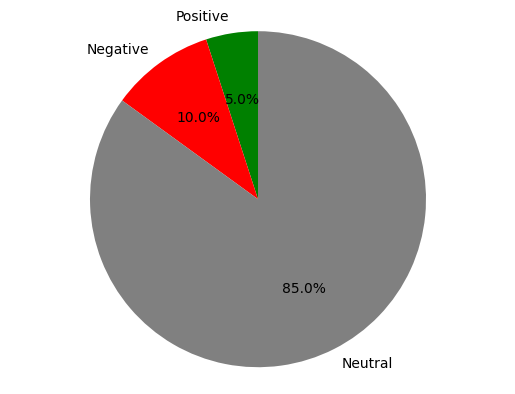

In [32]:
# option 1 - NLTK
#Statistics

# Initialize counters for different sentiment labels
positive_count = 0
negative_count = 0
neutral_count = 0

# Count the occurrences of each sentiment label
for scores in df_topgram_nltk['sentiment_score']:
    compound_score = scores['compound']
    if compound_score > 0.05:
        positive_count += 1
    elif compound_score < -0.05:
        negative_count += 1
    else:
        neutral_count += 1

# Calculate the relative frequencies of each sentiment label
total_count = len(df_topgram_nltk)
positive_percent = positive_count / total_count
negative_percent = negative_count / total_count
neutral_percent = neutral_count / total_count

# Visualize the sentiment distribution using a pie chart
labels = ['Positive', 'Negative', 'Neutral']
sizes = [positive_percent, negative_percent, neutral_percent]
colors = ['green', 'red', 'gray']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

In [33]:
# option 2 - TextBlob

from textblob import TextBlob

In [34]:
# option 2 - TextBlob

# Perform sentiment analysis on each financial data point
sentiments_textblob = []

for word in list_topgram:
    blob = TextBlob(word)
    polarity = blob.sentiment.polarity

    if polarity > 0:
        sentiment = "positive"
    elif polarity < 0:
        sentiment = "negative"
    else:
        sentiment = "neutral"

    sentiments_textblob.append({
        "Word": word,
        "Sentiment": sentiment
    })

sentiments_textblob_df = pd.DataFrame(sentiments_textblob)
print(sentiments_textblob_df)

# Convert sentiments list to a pandas DataFrame
df_topgram_textblob = pd.DataFrame(sentiments_textblob)

df_topgram_textblob

        Word Sentiment
0       fuck  negative
1     market   neutral
2        put   neutral
3        day   neutral
4         go   neutral
5      think   neutral
6       call   neutral
7        buy   neutral
8   tomorrow   neutral
9       time   neutral
10      make   neutral
11      shit  negative
12     money   neutral
13      good  positive
14     delet   neutral
15     peopl   neutral
16      year   neutral
17      know   neutral
18       got   neutral
19       spi   neutral


,Word,Sentiment
0,fuck,negative
1,market,neutral
2,put,neutral
3,day,neutral
4,go,neutral
5,think,neutral
6,call,neutral
7,buy,neutral
8,tomorrow,neutral
9,time,neutral


In [35]:
df_topgram_textblob.to_csv('gram_bert.csv')

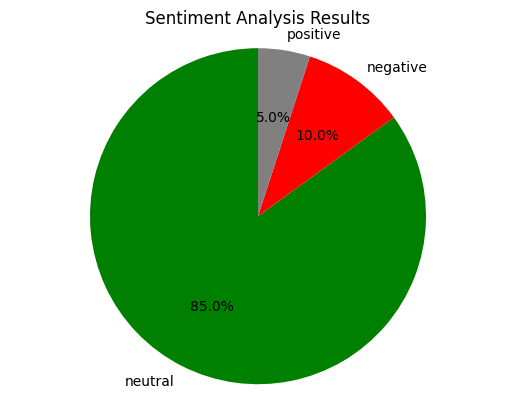

In [36]:
# option 2 - TextBlob
#Statistics

# Initialize counters for different sentiment labels
sentiment_counts = df_topgram_textblob['Sentiment'].value_counts()
labels = sentiment_counts.index.tolist()
sizes = sentiment_counts.values.tolist()

colors = ['green', 'red', 'gray']  # Customize colors for positive, negative, and neutral sentiments

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures a circular pie chart

plt.title('Sentiment Analysis Results')
plt.show()

In [37]:
#option 3 - specific for financial terms
# Embeddings

# Initialize an empty list to store word vectors
word_vectors = []

# Iterate over each word
for word in list_topgram:
    try:
        # Get the word vector from the GloVe embeddings dictionary
        vector = glove_embeddings[word]
        word_vectors.append(vector)
    except KeyError:
        print(f"Word '{word}' not found in the glove_embeddings dictionary.")
        word_vectors.append(np.zeros(len(glove_embeddings[next(iter(glove_embeddings))])))

# Create a DataFrame with the word vectors
columns = [f"dim_{i}" for i in range(len(word_vectors[0]))]
glove_embeddings_df = pd.DataFrame(word_vectors, index=list_topgram, columns=columns)
glove_embeddings_df.index.name = "Word"


glove_embeddings_df


,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_290,dim_291,dim_292,dim_293,dim_294,dim_295,dim_296,dim_297,dim_298,dim_299
Word,,,,,,,,,,,,,,,,,,,,,
fuck,-0.976320,-0.498310,-0.367790,0.070954,0.163400,-0.279330,-0.168510,-0.366830,0.038752,1.59550,...,0.624090,-0.275710,-0.431530,-0.471320,0.257940,-0.280310,-0.271020,0.236330,-0.481170,0.170760
market,-0.196040,0.536560,0.096780,0.091406,0.552390,-0.356280,0.044962,0.087634,0.160630,2.38870,...,-1.087800,0.476250,0.075284,-0.229940,-0.322600,-0.635040,-0.298900,-0.495300,0.433890,0.184770
put,0.025338,-0.007002,-0.247120,0.097579,-0.119940,-0.155640,-0.432600,-0.292870,-0.023622,2.53170,...,-0.261160,0.032081,0.191080,-0.082454,0.009148,-0.277050,0.033012,-0.023474,0.185170,-0.053836
day,-0.037723,0.278650,0.113530,-0.145210,-0.093572,-0.322320,-0.164990,0.084118,0.187850,2.77470,...,0.194380,0.032061,0.252870,-0.258230,-0.007297,-0.150810,0.003343,0.151850,-0.171250,0.040859
go,0.138930,-0.019056,-0.338910,0.121510,0.365230,-0.173910,-0.026735,-0.050335,0.247430,2.45310,...,-0.130470,0.072147,0.003366,-0.181810,0.031465,-0.035351,-0.004791,0.092753,0.286180,0.136460
think,-0.217880,0.441280,-0.432040,-0.198030,-0.002797,0.288030,0.080648,-0.146430,0.022300,2.59410,...,-0.150840,0.027544,-0.279390,0.038548,0.220030,0.182080,-0.507460,-0.164720,0.322550,0.305790
call,-0.273840,0.411270,-0.402950,0.379990,0.988830,-0.141960,0.343000,-0.325790,-0.287080,2.50680,...,0.033505,0.335890,-0.116330,0.078377,-0.093120,0.062870,-0.313840,0.161850,-0.512510,0.487540
buy,-0.386460,-0.009301,-0.186450,-0.402890,0.018726,0.011056,-0.539730,-0.334090,0.088768,1.53710,...,-0.370450,-0.026144,0.028192,0.003501,-0.085116,-0.237740,-0.201560,-0.565290,0.095978,0.878640
tomorrow,0.229250,0.398980,-0.148250,0.199730,0.000208,-0.568790,-0.086482,0.013450,0.012293,2.55620,...,0.037572,-0.168290,0.324900,-0.458550,0.035989,-0.395230,0.106990,-0.075183,-0.273280,0.009302


In [38]:
from sklearn.metrics.pairwise import cosine_similarity

# Input dataset (list of words and labels)
dataset = [
    ("fuck", "negative"),
    ("market", "neutral"),
    ("put", "negative"),
    ("day", "neutral"),
    ("go", "neutral"),
    ("think", "neutral"),
    ("call", "positive"),
    ("buy", "positive"),
    ("tomorrow", "neutral"),
    ("time", "neutral"),
    ("make", "neutral"),
    ("shit", "negative"),    
    ("money", "neutral"),    
    ("good", "positive"),
    ("delet", "negative"),
    ("peopl", "neutral"),   
    ("year", "neutral"),
    ("know", "neutral"),
    ("got", "neutral"),
    ("spi", "neutral"),

]

# Separate words and labels
words, labels = zip(*dataset)

# Calculate sentiment scores
sentiment_scores = {}
sentiment_categories = set(labels)

for category in sentiment_categories:
    # Collect word embeddings for the given sentiment category
    category_embeddings = [glove_embeddings[word] for word, label in dataset if label == category]

    # Calculate the average vector
    average_vector = np.mean(category_embeddings, axis=0)

    sentiment_scores[category] = average_vector

# Calculate sentiment scores for each word
word_sentiment_scores = {}

for word in words:
    word_vector = glove_embeddings[word]
    cosine_similarities = cosine_similarity([word_vector], list(sentiment_scores.values()))[0]
    word_sentiment_scores[word] = dict(zip(sentiment_scores.keys(), cosine_similarities))

# Create a DataFrame with the sentiment scores
df_cos_sim = pd.DataFrame.from_dict(word_sentiment_scores, orient='index')
df_cos_sim.columns = [f"{category.capitalize()} Sentiment Score" for category in sentiment_categories]
df_cos_sim.index.name = "Word"

df_cos_sim

,Negative Sentiment Score,Positive Sentiment Score,Neutral Sentiment Score
Word,,,
fuck,0.833982,0.415424,0.471263
market,0.099445,0.490764,0.549942
put,0.632251,0.655836,0.746817
day,0.308255,0.542816,0.742058
go,0.529533,0.697532,0.792515
think,0.530284,0.661342,0.779985
call,0.364279,0.734920,0.533804
buy,0.325063,0.772581,0.528320
tomorrow,0.330921,0.490166,0.662188


In [39]:
# taking frequency into account
# word frequency* word sentiment score
# Iterate over each row in df_top100gram
for index, row in df_topgram.iterrows():
    # Calculate the sum of all words frequency * positive sentiment score
    positive_sum = (row.iloc[:-1] * df_cos_sim['Positive Sentiment Score']).sum()

    # Calculate the sum of all words frequency * negative sentiment score
    negative_sum = (row.iloc[:-1] * df_cos_sim['Negative Sentiment Score']).sum()

    # Calculate the sum of all words frequency * neutral sentiment score
    neutral_sum = (row.iloc[:-1] * df_cos_sim['Neutral Sentiment Score']).sum()

    # Append the scores as new columns to df_top100gram
    df_topgram.at[index, 'Positive Score'] = positive_sum
    df_topgram.at[index, 'Negative Score'] = negative_sum
    df_topgram.at[index, 'Neutral Score'] = neutral_sum

# Print the updated df_top100gram
print(df_topgram)

#do the same on test set
for index, row in df_topgram_test.iterrows():
    # Calculate the sum of all words frequency * positive sentiment score
    positive_sum = (row.iloc[:-1] * df_cos_sim['Positive Sentiment Score']).sum()

    # Calculate the sum of all words frequency * negative sentiment score
    negative_sum = (row.iloc[:-1] * df_cos_sim['Negative Sentiment Score']).sum()

    # Calculate the sum of all words frequency * neutral sentiment score
    neutral_sum = (row.iloc[:-1] * df_cos_sim['Neutral Sentiment Score']).sum()

    # Append the scores as new columns to df_top100gram
    df_topgram_test.at[index, 'Positive Score'] = positive_sum
    df_topgram_test.at[index, 'Negative Score'] = negative_sum
    df_topgram_test.at[index, 'Neutral Score'] = neutral_sum



grams fuck market  put   day    go think call  buy tomorrow time  ... delet  \
0      569    414  507   701  1582   400  532  416      527  349  ...   250   
1      566    455  409  1005  1562   351  414  411      364  346  ...   330   
2      486    573  523   971  1700   330  458  424      569  381  ...   234   
3      473    360  412   746  1480   306  368  302      226  358  ...   265   
4      585    600  663   989  1718   388  565  446      470  394  ...   271   
..     ...    ...  ...   ...   ...   ...  ...  ...      ...  ...  ...   ...   
145    338    201  140   396  1049   201  308  233      155  243  ...   113   
146    434    287  308   573  1620   278  355  376      299  267  ...   178   
147    324    303  188   437  1074   256  324  233      198  273  ...   136   
148    508    393  282   583  1312   254  511  300      308  238  ...   131   
149    168    193  145   296   700   129  267  197       83  159  ...    99   

grams peopl year know  got spi        date Positive

In [40]:
# remove embeddings:

del glove_embeddings, fasttext_embeddings, glove_oov, fasttext_oov,
gc.collect()

2625

# 3. Prepare the Training dataset
  1. check for Duplicated labeled records

In [41]:
#Build X_train
# concat sentiment scores to 

train_df = train_df.join(df_topgram[['Positive Score', 'Neutral Score', 'Negative Score']], rsuffix='_topgram')
train_df 

# do the same to test set
test_df = test_df.join(df_topgram_test[['Positive Score', 'Neutral Score', 'Negative Score']], rsuffix='_topgram')
test_df 

,date,comments,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_SP500,percent_chnage_x,Jump_SP500,...,Big_Drop_NQ,new_text,embeddings_tokens,ngrams_embeddings_tokens,tokens,stemmed_tokens,stemmed_text,Positive Score,Neutral Score,Negative Score
0,2023-05-02,"I will be suing the market for $295,000 if it ...",12198.01953,12206.58008,12015.23047,12080.50977,12080.50977,5501410000,-0.963351,0,...,1,"suing market $295,000 pump shitty portfolio re...",suing market 295 000 pump shitty portfolio re...,suing market 295 000 pump shitty portfolio ret...,"[suing, market, 295, 000, pump, shitty, portfo...","[su, market, 295, 000, pump, shitti, portfolio...",su market 295 000 pump shitti portfolio retir ...,5024.359219,5678.274264,4083.893385
1,2023-05-03,AMD's only hope is that Su Bae spreads open he...,12097.04004,12212.54980,12022.45996,12025.33008,12025.33008,5782160000,-0.592789,0,...,0,"amd's hope su bae spreads open legs reveal ""a""...","amd s hope su bae spreads open legs reveal ""a""...","amd hope su bae spreads open legs reveal ""a"" ""...","[amd, hope, su, bae, spreads, open, legs, reve...","[amd, hope, su, bae, spread, open, leg, reveal...",amd hope su bae spread open leg reveal `` a ''...,4844.542607,5532.941506,3947.415250
2,2023-05-04,I fucking hate the stock market!!!! Been a bea...,11997.33984,12033.15039,11925.37012,11966.40039,11966.40039,4745780000,-0.257886,0,...,0,fucking hate stock market!!!! bear bank run lo...,fucking hate stock market bear bank run lo...,fucking hate stock market bear bank run lost ...,"[fucking, hate, stock, market, bear, bank, run...","[fuck, hate, stock, market, bear, bank, run, l...",fuck hate stock market bear bank run lost 70k ...,5196.744694,5936.066150,4100.179924
3,2023-05-05,"🍏✋😮‍💨✋🍎\n\n""Take the green aapl, and wake up t...",12073.03027,12264.83008,12065.71973,12235.41016,12235.41016,4574790000,1.344980,0,...,0,"""take green aapl, wake tomorrow like changed. ...","""take green aapl wake tomorrow like changed ...","""take green aapl wake tomorrow like changed re...","[``, take, green, aapl, wake, tomorrow, like, ...","[``, take, green, aapl, wake, tomorrow, like, ...",`` take green aapl wake tomorrow like chang re...,4271.226150,4895.476156,3544.895066
4,2023-05-08,Hardest part of Forex trading is telling your ...,12231.67969,12264.99023,12178.25977,12256.91992,12256.91992,4216360000,0.206351,1,...,0,hardest forex trading telling parents gay say ...,hardest forex trading telling parents gay say ...,hardest forex trading telling parents gay say ...,"[hardest, forex, trading, telling, parents, ga...","[hardest, forex, trade, tell, parent, gay, say...",hardest forex trade tell parent gay say time m...,5478.581053,6209.195254,4376.094286
5,2023-05-09,PLTR is up 16% and I’m still down 50% on my po...,12195.78027,12216.12988,12174.05957,12179.54980,12179.54980,4126780000,-0.133083,0,...,0,pltr 16% im 50% position woo damn. beating ear...,pltr 16 im 50 position woo damn beating ear...,pltr 16 50 position woo damn beating earnings ...,"[pltr, 16, 50, position, woo, damn, beating, e...","[pltr, 16, 50, posit, woo, damn, beat, earn, p...",pltr 16 50 posit woo damn beat earn pypl tank ...,4914.971579,5567.522954,4025.721458
6,2023-05-10,I did the math. I lost 15 years worth of savin...,12286.66016,12337.69043,12180.86035,12306.44043,12306.44043,4948260000,0.160990,1,...,0,math. lost 15 years worth savings year year. t...,math lost 15 years worth savings year year t...,math lost 15 years worth savings year year tha...,"[math, lost, 15, years, worth, savings, year, ...","[math, lost, 15, year, worth, save, year, year...",math lost 15 year worth save year year that de...,3512.939227,3996.266638,2970.454243
7,2023-05-11,>$BYND UP FOLLOWING EARNINGS AFTER ANNOUNCING ...,12321.25977,12347.37988,12255.44043,12328.50977,12328.50977,4489490000,0.058841,1,...,0,>$bynd following earnings announcing plans pro...,bynd following earnings announcing plans pro...,bynd following earnings announcing plans prod...,"[

In [42]:
# Build X_train

X_train_classify = train_df[['Positive Score','Neutral Score','Negative Score','Volume_SP500','Jump_SP500', 'Big_Jump_SP500', 'Drop_SP500', 'Big_Drop_SP500','Volume_NQ','Jump_NQ', 'Big_Jump_NQ', 'Drop_NQ', 'Big_Drop_NQ' ]]
X_train_classify

# do the same to test set
X_test_classify = test_df[['Positive Score','Neutral Score','Negative Score','Volume_SP500','Jump_SP500', 'Big_Jump_SP500', 'Drop_SP500', 'Big_Drop_SP500','Volume_NQ','Jump_NQ', 'Big_Jump_NQ', 'Drop_NQ', 'Big_Drop_NQ' ]]
X_test_classify

,Positive Score,Neutral Score,Negative Score,Volume_SP500,Jump_SP500,Big_Jump_SP500,Drop_SP500,Big_Drop_SP500,Volume_NQ,Jump_NQ,Big_Jump_NQ,Drop_NQ,Big_Drop_NQ
0,5024.359219,5678.274264,4083.893385,5501410000,0,0,1,0,4486130000,0,0,0,1
1,4844.542607,5532.941506,3947.415250,5782160000,0,0,1,0,4246510000,0,0,1,0
2,5196.744694,5936.066150,4100.179924,4745780000,0,0,1,0,4920090000,0,0,1,0
3,4271.226150,4895.476156,3544.895066,4574790000,0,1,0,0,4186270000,0,1,0,0
4,5478.581053,6209.195254,4376.094286,4216360000,1,0,0,0,3641640000,1,0,0,0
5,4914.971579,5567.522954,4025.721458,4126780000,0,0,1,0,3810140000,0,0,1,0
6,3512.939227,3996.266638,2970.454243,4948260000,1,0,0,0,4057160000,0,0,1,0
7,4952.208812,5615.174295,4088.874029,4489490000,1,0,0,0,3752900000,0,0,1,0
8,5901.689827,6685.431302,4761.932467,4170000000,0,0,1,0,3533740000,0,0,1,0
9,5305.735526,6061.452644,4231.810698,3979290000,1,0,0,0,3562170000,1,0,0,0


In [64]:
# Use NQ as label

X_train_binary = train_df[['Positive Score','Neutral Score','Negative Score','Volume_NQ']]
X_train_binary

# do the same to test set
X_test_binary = test_df[['Positive Score','Neutral Score','Negative Score','Volume_NQ']]
X_test_binary

,Positive Score,Neutral Score,Negative Score,Volume_NQ
0,5024.359219,5678.274264,4083.893385,4486130000
1,4844.542607,5532.941506,3947.415250,4246510000
2,5196.744694,5936.066150,4100.179924,4920090000
3,4271.226150,4895.476156,3544.895066,4186270000
4,5478.581053,6209.195254,4376.094286,3641640000
5,4914.971579,5567.522954,4025.721458,3810140000
6,3512.939227,3996.266638,2970.454243,4057160000
7,4952.208812,5615.174295,4088.874029,3752900000
8,5901.689827,6685.431302,4761.932467,3533740000
9,5305.735526,6061.452644,4231.810698,3562170000


##3.2. Time Series

In [65]:
# time series features

# Define the maximum number of lag variables to create
max_lag = 2

# Loop over each column in the DataFrame
for col in X_train_binary.columns[:4]:
    # Loop over each lag value
    for lag in range(1, max_lag + 1):
        # Create a new column name for the lag variable
        new_col_name = f"{col}_lag{lag}"
        # Shift the column by the lag value and assign it to a new column
        X_train_binary[new_col_name] = X_train_binary[col].shift(lag)

# Do the same for the test set
# Loop over each column in the DataFrame
for col in X_test_binary.columns[:4]:
    # Loop over each lag value
    for lag in range(1, max_lag + 1):
        # Create a new column name for the lag variable
        new_col_name = f"{col}_lag{lag}"
        # Shift the column by the lag value and assign it to a new column
        X_test_binary[new_col_name] = X_test_binary[col].shift(lag)

X_train_binary

/tmp/ipykernel_48/2380192878.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_binary[new_col_name] = X_train_binary[col].shift(lag)
/tmp/ipykernel_48/2380192878.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_binary[new_col_name] = X_train_binary[col].shift(lag)
/tmp/ipykernel_48/2380192878.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

,Positive Score,Neutral Score,Negative Score,Volume_NQ,Positive Score_lag1,Positive Score_lag2,Neutral Score_lag1,Neutral Score_lag2,Negative Score_lag1,Negative Score_lag2,Volume_NQ_lag1,Volume_NQ_lag2
0,5024.359219,5678.274264,4083.893385,4109390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4844.542607,5532.941506,3947.415250,4199690000,5024.359219,NaN,5678.274264,NaN,4083.893385,NaN,4.109390e+09,NaN
2,5196.744694,5936.066150,4100.179924,4143800000,4844.542607,5024.359219,5532.941506,5678.274264,3947.415250,4083.893385,4.199690e+09,4.109390e+09
3,4271.226150,4895.476156,3544.895066,4041070000,5196.744694,4844.542607,5936.066150,5532.941506,4100.179924,3947.415250,4.143800e+09,4.199690e+09
4,5478.581053,6209.195254,4376.094286,4185300000,4271.226150,5196.744694,4895.476156,5936.066150,3544.895066,4100.179924,4.041070e+09,4.143800e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
145,2804.523721,3157.972777,2268.912828,3978640000,2104.656566,2198.441592,2392.546549,2522.740930,1688.785950,1801.110241,3.290940e+09,3.611750e+09
146,3928.897786,4420.336524,3169.792346,3837030000,2804.523721,2104.656566,3157.972777,2392.546549,2268.912828,1688.785950,3.978640e+09,3.290940e+09
147,3117.071916,3533.111601,2482.705836,3750550000,3928.897786,2804.523721,4420.336524,3157.972777,3169.792346,2268.912828,3.837030e+09,3.978640e+09
148,3874.279091,4336.781289,3091.032770,4087800000,3117.071916,3928.897786,3533.111601,4420.336524,2482.705836,3169.792346,3.750550e+09,3.837030e+09


In [66]:

X_test_binary

,Positive Score,Neutral Score,Negative Score,Volume_NQ,Positive Score_lag1,Positive Score_lag2,Neutral Score_lag1,Neutral Score_lag2,Negative Score_lag1,Negative Score_lag2,Volume_NQ_lag1,Volume_NQ_lag2
0,5024.359219,5678.274264,4083.893385,4486130000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4844.542607,5532.941506,3947.415250,4246510000,5024.359219,NaN,5678.274264,NaN,4083.893385,NaN,4.486130e+09,NaN
2,5196.744694,5936.066150,4100.179924,4920090000,4844.542607,5024.359219,5532.941506,5678.274264,3947.415250,4083.893385,4.246510e+09,4.486130e+09
3,4271.226150,4895.476156,3544.895066,4186270000,5196.744694,4844.542607,5936.066150,5532.941506,4100.179924,3947.415250,4.920090e+09,4.246510e+09
4,5478.581053,6209.195254,4376.094286,3641640000,4271.226150,5196.744694,4895.476156,5936.066150,3544.895066,4100.179924,4.186270e+09,4.920090e+09
5,4914.971579,5567.522954,4025.721458,3810140000,5478.581053,4271.226150,6209.195254,4895.476156,4376.094286,3544.895066,3.641640e+09,4.186270e+09
6,3512.939227,3996.266638,2970.454243,4057160000,4914.971579,5478.581053,5567.522954,6209.195254,4025.721458,4376.094286,3.810140e+09,3.641640e+09
7,4952.208812,5615.174295,4088.874029,3752900000,3512.939227,4914.971579,3996.266638,5567.522954,2970.454243,4025.721458,4.057160e+09,3.810140e+09
8,5901.689827,6685.431302,4761.932467,3533740000,4952.208812,3512.939227,5615.174295,3996.266638,4088.874029,2970.454243,3.752900e+09,4.057160e+09
9,5305.735526,6061.452644,4231.810698,3562170000,5901.689827,4952.208812,6685.431302,5615.174295,4761.932467,4088.874029,3.533740e+09,3.752900e+09


In [67]:
# define time-series variables
#to handle the nan from lag variables

from sklearn.impute import SimpleImputer

# Impute NaN values using the mean of each column
imputer = SimpleImputer(strategy='mean')

# Select columns to impute
n_cols = X_train_binary.shape[1]
cols_to_impute = list(range(n_cols-8, n_cols))

X_train_binary.iloc[:,cols_to_impute] = imputer.fit_transform(X_train_binary.iloc[:,cols_to_impute])
# X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

X_train_binary

# do the same to test set
# Select columns to impute
n_cols_test = X_test_binary.shape[1]
cols_to_impute_test = list(range(n_cols_test-8, n_cols_test))

X_test_binary.iloc[:,cols_to_impute_test] = imputer.fit_transform(X_test_binary.iloc[:,cols_to_impute_test])
# X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

X_test_binary

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

,Positive Score,Neutral Score,Negative Score,Volume_NQ,Positive Score_lag1,Positive Score_lag2,Neutral Score_lag1,Neutral Score_lag2,Negative Score_lag1,Negative Score_lag2,Volume_NQ_lag1,Volume_NQ_lag2
0,5024.359219,5678.274264,4083.893385,4486130000,4819.958355,4794.550117,5477.978214,5446.675713,3918.247232,3903.417369,4.146356e+09,4.157886e+09
1,4844.542607,5532.941506,3947.415250,4246510000,5024.359219,4794.550117,5678.274264,5446.675713,4083.893385,3903.417369,4.486130e+09,4.157886e+09
2,5196.744694,5936.066150,4100.179924,4920090000,4844.542607,5024.359219,5532.941506,5678.274264,3947.415250,4083.893385,4.246510e+09,4.486130e+09
3,4271.226150,4895.476156,3544.895066,4186270000,5196.744694,4844.542607,5936.066150,5532.941506,4100.179924,3947.415250,4.920090e+09,4.246510e+09
4,5478.581053,6209.195254,4376.094286,3641640000,4271.226150,5196.744694,4895.476156,5936.066150,3544.895066,4100.179924,4.186270e+09,4.920090e+09
5,4914.971579,5567.522954,4025.721458,3810140000,5478.581053,4271.226150,6209.195254,4895.476156,4376.094286,3544.895066,3.641640e+09,4.186270e+09
6,3512.939227,3996.266638,2970.454243,4057160000,4914.971579,5478.581053,5567.522954,6209.195254,4025.721458,4376.094286,3.810140e+09,3.641640e+09
7,4952.208812,5615.174295,4088.874029,3752900000,3512.939227,4914.971579,3996.266638,5567.522954,2970.454243,4025.721458,4.057160e+09,3.810140e+09
8,5901.689827,6685.431302,4761.932467,3533740000,4952.208812,3512.939227,5615.174295,3996.266638,4088.874029,2970.454243,3.752900e+09,4.057160e+09
9,5305.735526,6061.452644,4231.810698,3562170000,5901.689827,4952.208812,6685.431302,5615.174295,4761.932467,4088.874029,3.533740e+09,3.752900e+09


## 4.1. check for Duplicated labeled records

In [47]:
# 2. Prepare the Training dataset
# Check for Duplicated labeled records
'''
# extract the list of "text"
df_mislabeled = consol_df.groupby(['comments']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

'''

'\n# extract the list of "text"\ndf_mislabeled = consol_df.groupby([\'comments\']).nunique().sort_values(by=\'target\', ascending=False)\ndf_mislabeled = df_mislabeled[df_mislabeled[\'target\'] > 1][\'target\']\ndf_mislabeled.index.tolist()\n\n'

In [48]:
# check for Duplicated labeled records

duplicated_rows = X_train_binary.duplicated()

duplicated_rows.describe()

count       150
unique        1
top       False
freq        150
dtype: object

In [49]:
# check for Duplicated labeled records
# do the same to test set
duplicated_rows = X_test_binary.duplicated()

duplicated_rows.describe()

count        41
unique        1
top       False
freq         41
dtype: object

In [50]:
# Check for Duplicated labeled records
# review and relabel the text one by one

In [51]:
# check for Duplicated labeled records in test set

'''
duplicated_rows_test = df_freq_test.duplicated()

duplicated_rows_test.describe()
'''

'\nduplicated_rows_test = df_freq_test.duplicated()\n\nduplicated_rows_test.describe()\n'

In [54]:
#create label

Y_train_binary = pd.DataFrame()

#binary
Y_train_binary['date'] = train_df['date']
Y_train_binary["Up"] = train_df['Jump_NQ'] + train_df['Big_Jump_NQ']
Y_train_binary["Down"] = train_df['Drop_NQ'] + train_df['Big_Drop_NQ']

# 4 classes
# SP500_train=df_freq_train[['Jump_SP500','Big_Jump_SP500','Drop_SP500', 'Big_Drop_SP500']]
# NQ_train=df_freq_train[['Jump_NQ','Big_Jump_NQ','Drop_NQ', 'Big_Drop_NQ']]

Y_train_binary

#do the same to test set
#create label

Y_test_binary = pd.DataFrame()

#binary
Y_test_binary['date'] = test_df['date']
Y_test_binary["Up"] = test_df['Jump_NQ'] + test_df['Big_Jump_NQ']
Y_test_binary["Down"] = test_df['Drop_NQ'] + test_df['Big_Drop_NQ']

# 4 classes
# SP500_train=df_freq_train[['Jump_SP500','Big_Jump_SP500','Drop_SP500', 'Big_Drop_SP500']]
# NQ_train=df_freq_train[['Jump_NQ','Big_Jump_NQ','Drop_NQ', 'Big_Drop_NQ']]

Y_train_binary

,date,Up,Down
0,2022-07-13,1,0
1,2022-07-14,1,0
2,2022-07-15,1,0
3,2022-07-19,1,0
4,2022-07-20,1,0
...,...,...,...
145,2023-04-25,0,1
146,2023-04-26,0,1
147,2023-04-27,1,0
148,2023-04-28,1,0


In [68]:
X_test_binary

,Positive Score,Neutral Score,Negative Score,Volume_NQ,Positive Score_lag1,Positive Score_lag2,Neutral Score_lag1,Neutral Score_lag2,Negative Score_lag1,Negative Score_lag2,Volume_NQ_lag1,Volume_NQ_lag2
0,5024.359219,5678.274264,4083.893385,4486130000,4819.958355,4794.550117,5477.978214,5446.675713,3918.247232,3903.417369,4.146356e+09,4.157886e+09
1,4844.542607,5532.941506,3947.415250,4246510000,5024.359219,4794.550117,5678.274264,5446.675713,4083.893385,3903.417369,4.486130e+09,4.157886e+09
2,5196.744694,5936.066150,4100.179924,4920090000,4844.542607,5024.359219,5532.941506,5678.274264,3947.415250,4083.893385,4.246510e+09,4.486130e+09
3,4271.226150,4895.476156,3544.895066,4186270000,5196.744694,4844.542607,5936.066150,5532.941506,4100.179924,3947.415250,4.920090e+09,4.246510e+09
4,5478.581053,6209.195254,4376.094286,3641640000,4271.226150,5196.744694,4895.476156,5936.066150,3544.895066,4100.179924,4.186270e+09,4.920090e+09
5,4914.971579,5567.522954,4025.721458,3810140000,5478.581053,4271.226150,6209.195254,4895.476156,4376.094286,3544.895066,3.641640e+09,4.186270e+09
6,3512.939227,3996.266638,2970.454243,4057160000,4914.971579,5478.581053,5567.522954,6209.195254,4025.721458,4376.094286,3.810140e+09,3.641640e+09
7,4952.208812,5615.174295,4088.874029,3752900000,3512.939227,4914.971579,3996.266638,5567.522954,2970.454243,4025.721458,4.057160e+09,3.810140e+09
8,5901.689827,6685.431302,4761.932467,3533740000,4952.208812,3512.939227,5615.174295,3996.266638,4088.874029,2970.454243,3.752900e+09,4.057160e+09
9,5305.735526,6061.452644,4231.810698,3562170000,5901.689827,4952.208812,6685.431302,5615.174295,4761.932467,4088.874029,3.533740e+09,3.752900e+09


In [69]:
# output
X_train_binary.to_csv('X_train_binary.csv')
Y_train_binary.to_csv('Y_train_binary.csv')

In [70]:
# output
X_test_binary.to_csv('X_test_binary.csv')
Y_test_binary.to_csv('Y_test_binary.csv')